In [2]:
import numpy as np
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython import display
from IPython.display import HTML
from quick_sim import setup_sim
from edward_tools.coupled_fq_potential import coupled_flux_qubit_bit_flip_pot_1, coupled_flux_qubit_bit_flip_force_1
from edward_tools.visualization import animate_sim_flux_qubit

import kyle_tools as kt
import matplotlib.pyplot as plt

import importlib, os
from edward_tools import coupled_fq_protocol_library, cfq_runner
# from PARAMETER_INPUT import *
# from PARAMETER_INPUT import _lambda, _theta, _eta

from edward_tools import coupled_fq_protocol_library
import edward_tools.cfq_batch_sweep as cfq_batch_sweep
%load_ext jupyternotify

coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system
get_potential_shot_at_different_t = coupled_fq_protocol_library.get_potential_shot_at_different_t
get_potential_shot_at_different_t_1D = coupled_fq_protocol_library.get_potential_shot_at_different_t_1D
create_simple_protocol_parameter_dict = coupled_fq_protocol_library.create_simple_protocol_parameter_dict
coupled_fq_runner = importlib.reload(cfq_runner)
coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system


<IPython.core.display.Javascript object>

In [3]:
PHI_0 = 2.067833848 * 1e-15
k_B = 1.38e-23
T = 0.5
k_BT = k_B * T

In [4]:
I_p_1, I_p_2 = 2e-6 , 2e-6  # Amp
I_m_1, I_m_2 = 7e-9, 1e-9                                # Amp
R_1, R_2 = 371, 371                                # ohm
C_1, C_2 = 4e-9, 4e-9                              # F
L_1, L_2 = 1e-9, 1e-9                              # H

quick_doubler = lambda x1, x2: np.hstack([np.array([x1] * 2), np.array([x2]*2)])
I_p, I_m = quick_doubler(I_p_1, I_p_2), quick_doubler(I_m_1, I_m_2)

m_c = C_1
m_1 = C_1
m_2 = C_2
x_c = PHI_0 / (2 * np.pi)
time_scale_factor = 1
t_c = np.sqrt(L_1 * C_1)


U0_1 = m_c * x_c**2 / t_c
U0_2 = m_2 * x_c**2 / t_c
kappa_1, kappa_2, kappa_3, kappa_4 = k_BT/U0_1, k_BT/U0_1, k_BT/U0_1, k_BT/U0_1




lambda_1 = 2 * np.sqrt(L_1 * C_1) / (C_1 * R_1)
theta_1  = 1
eta_1    = (L_1 * C_1 / R_1**2)**0.25 * np.sqrt(2 * kappa_1)

lambda_2 = 2 * np.sqrt(L_1 * C_1) / (C_2 * R_2)
theta_2  = 1 / (C_2/C_1)
eta_2    = (L_1 * C_1 / R_1**2)**0.25 * np.sqrt(2 * kappa_2 * (R_1 * C_1) / (R_2 * C_2))

lambda_3 = 2 * np.sqrt(L_1 * C_1) / (C_1 * R_1)
theta_3  = 4
eta_3    = (L_1 * C_1 / R_1**2)**0.25 * np.sqrt(2 * kappa_3)

lambda_4 = 2 * np.sqrt(L_1 * C_1) / (C_2 * R_2)
theta_4  = 4 / (C_2/C_1)
eta_4    = (L_1 * C_1 / R_1**2)**0.25 * np.sqrt(2 * kappa_4 * (R_1 * C_1) / (R_2 * C_2))

gamma = 20


beta_1 = 2 * np.pi * L_1 * I_p_1 / PHI_0; 
beta_2 = 2 * np.pi * L_2 * I_p_2 / PHI_0;

d_beta_1 = 2 * np.pi * L_1 * I_m_1 / PHI_0; 
d_beta_2 = 2 * np.pi * L_2 * I_m_2 / PHI_0;

In [5]:
_lambda = np.array([lambda_1, lambda_2, lambda_3, lambda_4])
_theta  = np.array([theta_1, theta_2, theta_3, theta_4])
_eta  =   np.array([eta_1, eta_2, eta_3, eta_4])

In [6]:
"""
# step 0: modify parameters
- All the parameters are stored in a separate file PARAMETER_INPUT
- You can override some of the parameters here.
"""
params = {}
params['N'] = 10_000
params['dt'] = 1.0/5_00
params['lambda'] = 1
params['beta'] = 1
params['sim_params'] = [_lambda, _theta, _eta]
params['target_work'] = None
params['comment'] = ""

In [7]:
"""
# step 1: Define potential
"""

coupled_fq_default_param = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x_c]
[phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound] = np.array([4, 4, 4, 4])/time_scale_factor

coupled_fq_domain = [[-phi_1_bound, -phi_2_bound, -phi_1dc_bound, -phi_2dc_bound], \
                     [phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound]]

coupled_fq_pot = Potential(coupled_flux_qubit_bit_flip_pot_1, coupled_flux_qubit_bit_flip_force_1, 14, 4,\
                           default_params = coupled_fq_default_param,  relevant_domain = coupled_fq_domain)

In [8]:
params

{'N': 10000,
 'dt': 0.002,
 'lambda': 1,
 'beta': 1,
 'sim_params': [array([0.00269542, 0.00269542, 0.00269542, 0.00269542]),
  array([1., 1., 4., 4.]),
  array([0.01853177, 0.01853177, 0.01853177, 0.01853177])],
 'target_work': None,
 'comment': ''}

In [36]:
"""
# step 2: Define initial condition and protocol
"""
zeroDissipation = True
params['sim_params'] = [_lambda, _theta, _eta]
if zeroDissipation:
    params['sim_params'] = [_lambda * 0, _theta, _eta * 0]


manual_domain=[np.array([-5, -5]), np.array([5, 5])]

g_1_i = 1; 
beta_1_i = - np.pi**2;

initial_parameter_dict = {
        "U0_1": U0_1,     "U0_2": U0_2,     "gamma_1": g_1_i,  "gamma_2": 0,
        "beta_1": beta_1_i,   "beta_2": 0,   "d_beta_1": 0 ,   "d_beta_2": 0,
        "phi_1_x": 0,  "phi_2_x": 0,  "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_1_dcx_off,
        "M_12": M_12_off, 'x_c': x_c
}
# a_x, a_y, b_x, b_y, c_x, c_y, d = params
# g_1 = 1, g_2 = 1, beta_1 = -1.0, beta_2 = -1.0, delta_beta_1 = 0, delta_beta_2 = 0, phi_1x = 0


# The duration is half period, which is π * \sqrt{m/k}
protocol_list_options = [
    {"placeholder": ""},
    {"duration": np.pi * np.sqrt(1/abs(beta_1_i)), "gamma_1": 0, "beta_1": -beta_1_i,  "name":"(1) computation potential"},
    {"duration": 1, "gamma_1": g_1_i, "beta_1": beta_1_i,  "name":"(1) mix in y direction"},
]

In [37]:
beta_1_i

-9.869604401089358

In [38]:
params['sim_params'] = [_lambda, _theta, _eta]

protocol_list = [protocol_list_options[2], protocol_list_options[1], protocol_list_options[2]]
protocol_list = [protocol_list_options[1]]
# print(params['sim_params'])
print(initial_parameter_dict["gamma_1"], initial_parameter_dict["beta_1"])
for x in protocol_list:
    print(x)

1 -9.869604401089358
{'duration': 1.0, 'gamma_1': 0, 'beta_1': 9.869604401089358, 'name': '(1) computation potential'}


In [25]:
"""
# First system
"""
computation_protocol_parameter_dict = coupled_fq_protocol_library.customizedProtocol(initial_parameter_dict, \
                                                                    protocol_list)
storage_protocol, comp_protocol = create_system(computation_protocol_parameter_dict)

comp_protocol.protocol_array[0].interpolation = "step"
# comp_protocol.protocol_array[1].interpolation = "step"
# comp_protocol.protocol_array[2].interpolation = "step"

cfqr = cfq_runner.coupledFluxQubitRunner(potential = coupled_fq_pot, params = params, \
                                                storage_protocol= storage_protocol, \
                                                computation_protocol= comp_protocol, percentage=1.0)


In [26]:
cfqr.initialize_sim()
cfqr.set_sim_attributes()
init_state_saved = cfqr.init_state

generating new initial_state
using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 10302 samples out of 10000
from system: finish the while loop in sampling.
as step value: slice(None, None, None), sampleSize: 10000
slice(None, None, None)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.002
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 1. 4. 4.] and eta: [0.01853177 0.01853177 0.01853177 0.01853177]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 2.8284271247461903
from simulation.py: number of steps: 1414, dt: 0.002


(array([ 11.,  70., 214., 485., 812., 897., 840., 696., 434., 277., 141.,
         74.,  40.,  18.,  11.,   9.,   7.,   4.,   4.,   1.,   2.,   1.,
          3.,   1.,   9.,  14.,  20.,  31.,  78., 146., 247., 417., 660.,
        864., 889., 808., 465., 211.,  74.,  15.]),
 array([-2.18890477e+00, -2.07941130e+00, -1.96991783e+00, -1.86042436e+00,
        -1.75093089e+00, -1.64143742e+00, -1.53194396e+00, -1.42245049e+00,
        -1.31295702e+00, -1.20346355e+00, -1.09397008e+00, -9.84476615e-01,
        -8.74983146e-01, -7.65489678e-01, -6.55996209e-01, -5.46502741e-01,
        -4.37009272e-01, -3.27515804e-01, -2.18022336e-01, -1.08528867e-01,
         9.64601136e-04,  1.10458070e-01,  2.19951538e-01,  3.29445006e-01,
         4.38938475e-01,  5.48431943e-01,  6.57925412e-01,  7.67418880e-01,
         8.76912348e-01,  9.86405817e-01,  1.09589929e+00,  1.20539275e+00,
         1.31488622e+00,  1.42437969e+00,  1.53387316e+00,  1.64336663e+00,
         1.75286010e+00,  1.86235356e+00, 

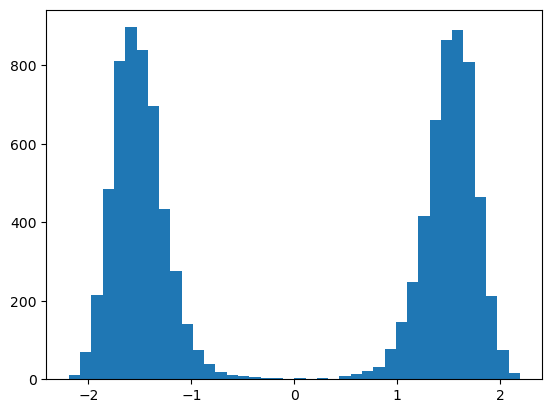

In [33]:
plt.hist(init_state_saved[:, 0, 0], bins = 40)

# real simulation

In [39]:
# step 5: perform simulations

simResult = cfq_batch_sweep.simulateSingleCoupledFluxQubit(params, initial_parameter_dict, protocol_list, \
                        potential = coupled_fq_pot, potential_default_param = coupled_fq_default_param,            
                        initial_state = None, manual_domain = manual_domain, \
                        phi_1_dcx = phi_1_dcx,  phi_2_dcx = phi_2_dcx, \
                        percentage = 1, as_step = np.s_[::])

cfqr = simResult["cfqr"]

print(f"simulation_date = {simResult['simulation_data']['simulation_date']}")
print(f"simulation time = {simResult['simulation_data']['simulation_time']}s")


 initializing...
generating new initial_state
using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 10002 samples out of 10000
from system: finish the while loop in sampling.
as step value: slice(None, None, None), sampleSize: 10000
slice(None, None, None)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.002
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 1. 4. 4.] and eta: [0.01853177 0.01853177 0.01853177 0.01853177]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 1.0
from simulation.py: number of steps: 500, dt: 0.002

 running sim...
final_statestep 499
all_state
work_done

 analyzing output...
For the states, 
(4.058881044387817,)
simulation_date = 2024-01-15 14:25:52.861925
simulation time = (4.058881044387817,)s


# animations

In [40]:
# animations
vmin, vmax = 0, 100
frame_skip = 50
# phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx
all_state = simResult["cfqr"].sim.output.all_state['states']
simResult["cfqr"].system.protocol_list = protocol_list
time_range = (computation_protocol_parameter_dict["t"][0], computation_protocol_parameter_dict["t"][-1])

ani,_,_ = animate_sim_flux_qubit(all_state, system = simResult["cfqr"].system ,
                                   times = time_range, frame_skip=frame_skip, color_by_state=True,
                                   vmin = vmin, vmax = vmax,
                                   manual_domain = manual_domain)



In [41]:
from IPython.display import HTML
from IPython import display
print(f"simulation_date = {simResult['simulation_data']['simulation_date']}")
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

simulation_date = 2024-01-15 14:25:52.861925


array([0., 0., 0., ..., 0., 0., 0.])

# work analysis

## work distributions

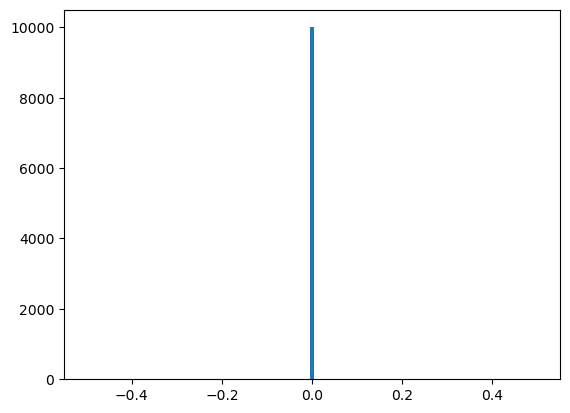

simulation_date = 2024-01-15 13:54:21.079250
mean work = 0.000 ± 0.00000
jarzyn = 1.000 ± 0.00000
[2.0]


In [41]:
work_distribution = simResult["cfqr"].sim.output.final_W

step_time_array = np.cumsum(np.array([x["duration"] for x in protocol_list]))/params['dt']
name_array = [x["name"] for x in protocol_list]

from scipy.stats import sem 

plt.hist(work_distribution, bins = 95)
plt.show()
jarzyn_term = np.mean(np.exp(-work_distribution))

avg_W = np.mean(work_distribution)
error_W = sem(work_distribution)
jarzyn_term_error = np.exp(-avg_W) * error_W

print(f"simulation_date = {simResult['simulation_data']['simulation_date']}")
print(f"mean work = {avg_W:.3f} ± {error_W:.5f}")
print(f'jarzyn = {jarzyn_term:.3f} ± {jarzyn_term_error:.5f}')
print([x["duration"] for x in protocol_list])

## work statistics

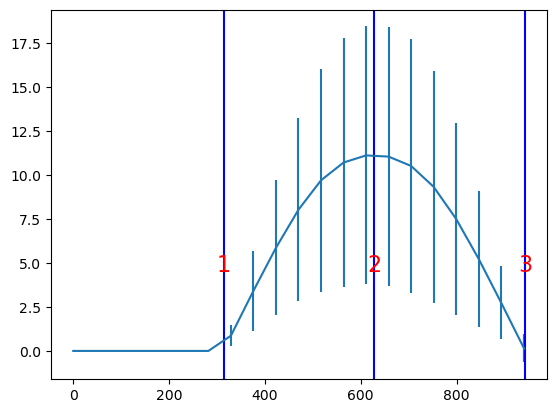

In [150]:
step_array = np.arange(simResult["work_statistic"][:,0].shape[0])
skip_step = int(len(step_array) * 0.05)
work_mean = simResult["work_statistic"][:,0]
work_std = simResult["work_statistic"][:,1]

coarse_step_array = step_array[::skip_step]
coarse_step_array = np.append(coarse_step_array, step_array[-1])
coarse_work_mean_array = work_mean[::skip_step]
coarse_work_mean_array = np.append(coarse_work_mean_array, work_mean[-1])
coarse_work_std_array = np.append(work_std[::skip_step], work_std[-1])

plt.errorbar(coarse_step_array, coarse_work_mean_array, yerr = coarse_work_std_array * 3)

for i, t in enumerate(step_time_array):
    plt.axvline(x = t, color = 'b', label = 'axvline - full height')
    # plt.text('2017-07-02 16:30:00',0.005,'BigNews1',rotation=90,va='top')
    plt.annotate(f"{i+1}", 
            xy=(t, 4.5),  
            # xytext=(quantile_75, 2.05*1e9),
            color='red', 
            ha='center', 
            size=16)

# saveToDataBase(simResult)

In [151]:
readyToSave = input("are you ready to save? (y/n)")
if readyToSave == "y":
    saveToDataBase(simResult)
else:
    print("data is not saved")

are you ready to save? (y/n) n


data is not saved


-0.6931471805599453

# crook analysis

## type 1

In [152]:
counts, bin_edges = np.histogram(simResult["work_distribution"], bins = np.linspace(-2, 2, 50),density=True)
counts, bin_edges = np.histogram(simResult["work_distribution"], bins = np.linspace(-0.2, 0.2, 20),density=True)

In [153]:
log_P_ratio = np.log(counts / counts[::-1])

Text(0, 0.5, 'log ratio')

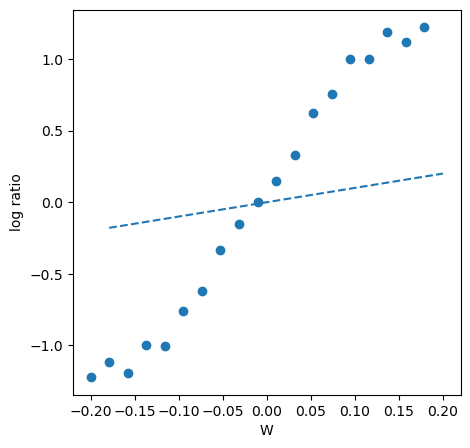

In [154]:
plt.figure(figsize=(5, 5))
plt.plot(bin_edges[1:], bin_edges[1:], "--")
plt.scatter(bin_edges[:-1], log_P_ratio)
plt.xlabel("W")
plt.ylabel("log ratio")

## type 2

dw = 0.001, dt = 0.003183098861837907, N = 10000
LHS: number of +W, RHS = number of -W * np.exp(+W)]


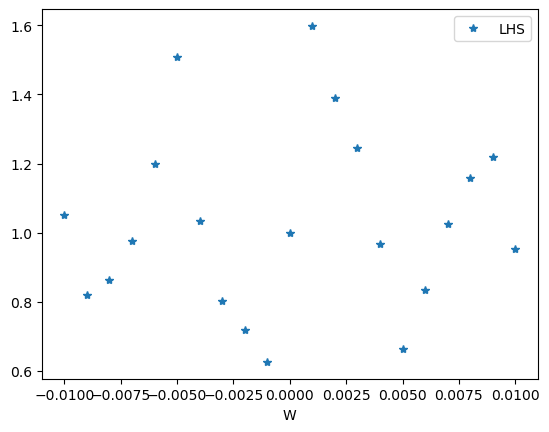

mean work = 0.127 and the std error of W = 0.00261
jarzyn = 0.911, std error= 0.00230
[1, 1.0, 1]
80 40 80 80 60 60


In [165]:
# crook analysis
# np.linspace(0.005, 0.2, 100)
test_w = np.linspace(-0.01, 0.01, 21)
dw = 0.001
crook_analysis_result = []

for _w in test_w:
    array = simResult["work_distribution"]

    # The 0 index is to remove the single element array
    number_of_plus_W = len(np.where(np.logical_and(array <= _w + dw, array >= _w - dw))[0])
    number_of_minus_W = len(np.where(np.logical_and(array <= -_w + dw, array >= -_w - dw))[0])
    crook_analysis_result.append(np.array([_w, number_of_plus_W, number_of_minus_W * np.exp(_w)]))

crook_analysis_result = np.array(crook_analysis_result)    
print(f"dw = {dw}, dt = {params['dt']}, N = {params['N']}")
print("LHS: number of +W, RHS = number of -W * np.exp(+W)]")
all_w = crook_analysis_result[:, 0]
all_lhs = crook_analysis_result[:, 1]
all_rhs = crook_analysis_result[:, 2]
plt.xlabel("W")
plt.plot(all_w, all_lhs/all_rhs, "*", label = "LHS")
# plt.plot(all_w, all_rhs, "-", label = "RHS")
plt.legend()
plt.show()
# print("p(W) = p(-W) exp(W)")
# print(f"LHS = {number_of_plus_W}, RHS = {number_of_minus_W * np.exp(test_w)}")
print(f"mean work = {avg_W:.3f} and the std error of W = {error_W:.5f}")
print(f'jarzyn = {jarzyn_term:.3f}, std error= {jarzyn_term_error:.5f}')
print([x["duration"] for x in protocol_list])
print(time_length_1, time_length_2, time_length_3, time_length_4, time_length_5, time_length_6)

In [163]:
result = {"N": params['N'], "dt": params['dt'], "W_mean": avg_W, "W_std": error_W, 
          "jarzyn": jarzyn_term, "jarzyn_error": jarzyn_term_error}

In [48]:
jarzyn_err_analytic = [ np.exp(-s["W_mean"]) * s["W_std"] for s in data]

NameError: name 'data' is not defined

(array([ 4.,  9., 31., 46., 51., 57., 47., 30., 20.,  7.]),
 array([0.00252326, 0.0025378 , 0.00255233, 0.00256687, 0.0025814 ,
        0.00259594, 0.00261047, 0.00262501, 0.00263954, 0.00265407,
        0.00266861]),
 <BarContainer object of 10 artists>)

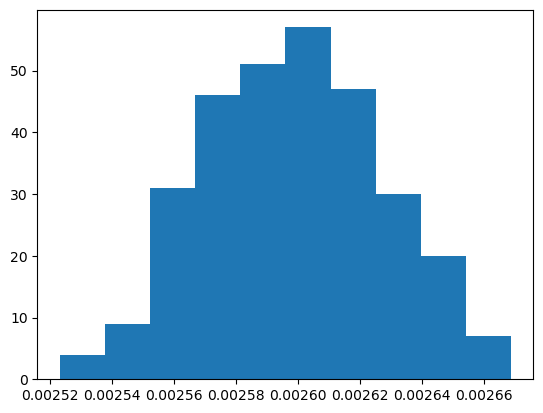

In [14]:
plt.hist(jarzyn_err_analytic)

In [ ]:
# save data

In [30]:
simResult["simulation_data"]["simulation_id"]

'acf216966e7205bddea5bbad21b5364a89a6a80bd063d8586991edde9f89b447'

In [ ]:


# step_array = np.arange(simResult["work_statistic"][:,0].shape[0])
# skip_step = int(len(step_array) * 0.02)
# work_mean = simResult["work_statistic"][:,0]
# work_std = simResult["work_statistic"][:,1]

# coarse_step_array = step_array[::skip_step]
# coarse_step_array = np.append(coarse_step_array, step_array[-1])
# coarse_work_mean_array = work_mean[::skip_step]
# coarse_work_mean_array = np.append(coarse_work_mean_array, work_mean[-1])
# coarse_work_std_array = np.append(work_std[::skip_step], work_std[-1])

# plt.errorbar(coarse_step_array, coarse_work_mean_array, yerr = coarse_work_std_array)

# for i, t in enumerate(step_time_array):
#     plt.axvline(x = t, color = 'b', label = 'axvline - full height')
#     # plt.text('2017-07-02 16:30:00',0.005,'BigNews1',rotation=90,va='top')
#     plt.annotate(f"{i+1}", 
#             xy=(t, 4.5),  
#             # xytext=(quantile_75, 2.05*1e9),
#             color='red', 
#             ha='center', 
#             size=16)

# print(f'jarzyn = {jarzyn_term}')
# print([x["duration"] for x in protocol_list])

# first_half = work_mean[0: len(work_mean)//2]
# second_half = work_mean[len(work_mean)//2:][::-1]
# plt.plot(step_array[0:len(step_array)//2], np.abs(first_half - second_half))

In [ ]:
# print(initial_parameter_dict["phi_1_dcx"], initial_parameter_dict["phi_2_dcx"], initial_parameter_dict["M_12"])
# print(protocol_list)

In [42]:
# animations
vmin, vmax = 0, 100
frame_skip = 10
# phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx
all_state = simResult["cfqr"].sim.output.all_state['states']
simResult["cfqr"].system.protocol_list = protocol_list
time_range = (computation_protocol_parameter_dict["t"][0], computation_protocol_parameter_dict["t"][-1])

ani,_,_ = animate_sim_flux_qubit(all_state, system = simResult["cfqr"].system ,
                                   times = time_range, frame_skip=frame_skip, color_by_state=True,
                                   vmin = vmin, vmax = vmax,
                                   manual_domain = manual_domain)

In [43]:
# from IPython.display import HTML
from IPython import display
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

In [ ]:
# import time
# now = str(time.time())
# sim_id = hashlib.sha256(bytes(now, encoding='utf8')).hexdigest()




# # save image and distributions
# np.save(f'cfq_data/tr_analysis/{sim_id}_work_distribution.npy', simResult["work_distribution"])
# plt.hist(simResult["work_distribution"], bins = 45)
# plt.savefig(f'cfq_data/tr_analysis/{sim_id}_work_distribution.png')
# plt.close()

# np.save(f'cfq_data/tr_analysis/{sim_id}_work_statistic.npy', simResult["work_statistic"])
# plt.errorbar(coarse_step_array, coarse_work_mean_array, yerr = coarse_work_std_array)
# plt.plot(step_array[0:len(step_array)//2], np.abs(first_half - second_half))
# plt.savefig(f'cfq_data/tr_analysis/{sim_id}_work_statistic.png')
# plt.close()

# np.save(f"cfq_data/tr_analysis/{sim_id}_state.npy", cfqr.sim.output.all_state["states"])

In [46]:
# get_potential_shot_at_different_t_1D(cfqr, computation_protocol_parameter_dict, manual_domain = manual_domain)

In [20]:
import json
import numpy as np
import matplotlib.pyplot as plt

Z_score = 2
N = 302
with open("cfq_data/variance_analysis_for_TRS_3.json") as f:
    data = json.load(f)
    W_mean_samples = np.array([d["W_mean"] for d in data])
    W_mean_err_samples = np.array([d["W_std"] for d in data])
    jarzyn_samples = np.array([d["jarzyn"] for d in data])
    jarzyn_err_samples = np.array([d["jarzyn_error"] for d in data])
    
    jarzyn_err_expt = np.std(jarzyn_samples)
    jarzyn_err_analytic = np.mean([ np.exp(-s["W_mean"]) * s["W_std"] for s in data])
    print("expt error: ", jarzyn_err_expt)
    print("analytic error: ", jarzyn_err_analytic)


#     data.append(result)
#     with open("cfq_data/variance_analysis_for_TRS_3.json", "w") as f_w:
#         json.dump(data, f_w)

expt error:  0.0028026377563410134
analytic error:  0.002599044763044375


In [23]:
import json
import numpy as np
import matplotlib.pyplot as plt

Z_score = 2
N = 302
with open("cfq_data/variance_analysis_for_TRS_whole_forward.json") as f:
    data = json.load(f)
    print(data)
#     W_mean_samples = np.array([d["W_mean"] for d in data])
#     W_mean_err_samples = np.array([d["W_std"] for d in data])
#     jarzyn_samples = np.array([d["jarzyn"] for d in data])
#     jarzyn_err_samples = np.array([d["jarzyn_error"] for d in data])
    
#     jarzyn_err_expt = np.std(jarzyn_samples)
#     jarzyn_err_analytic = np.mean([ np.exp(-s["W_mean"]) * s["W_std"] for s in data])
#     print("expt error: ", jarzyn_err_expt)
#     print("analytic error: ", jarzyn_err_analytic)


#     data.append(result)
#     with open("cfq_data/variance_analysis_for_TRS_3.json", "w") as f_w:
#         json.dump(data, f_w)

[{'N': 10000, 'dt': 0.01, 'W_mean': -1.395085503630883, 'W_std': 0.0047165293859287695, 'jarzyn': 4.457250222061053, 'jarzyn_error': 0.019032703438973876, 'fidelity': [{'initial': {'location': '00', 'count': 267}, 'final': [{'location': '00', 'count': 175}, {'location': '10', 'count': 89}]}, {'initial': {'location': '01', 'count': 211}, 'final': [{'location': '00', 'count': 132}, {'location': '10', 'count': 77}]}, {'initial': {'location': '10', 'count': 225}, 'final': [{'location': '01', 'count': 67}, {'location': '11', 'count': 157}]}, {'initial': {'location': '11', 'count': 297}, 'final': [{'location': '01', 'count': 85}, {'location': '11', 'count': 207}]}]}, {'N': 10000, 'dt': 0.01, 'W_mean': -1.4001202129991168, 'W_std': 0.004700211510623013, 'jarzyn': 4.474290097389955, 'jarzyn_error': 0.01906258899530266, 'fidelity': [{'initial': {'location': '00', 'count': 298}, 'final': [{'location': '00', 'count': 197}, {'location': '10', 'count': 99}]}, {'initial': {'location': '01', 'count':

In [26]:
f = data[0]["fidelity"]

[{'initial': {'location': '00', 'count': 267},
  'final': [{'location': '00', 'count': 175},
   {'location': '10', 'count': 89}]},
 {'initial': {'location': '01', 'count': 211},
  'final': [{'location': '00', 'count': 132},
   {'location': '10', 'count': 77}]},
 {'initial': {'location': '10', 'count': 225},
  'final': [{'location': '01', 'count': 67},
   {'location': '11', 'count': 157}]},
 {'initial': {'location': '11', 'count': 297},
  'final': [{'location': '01', 'count': 85},
   {'location': '11', 'count': 207}]}]

In [28]:
summaryText = ""
for x in f:
    initialLocation = x["initial"]["location"]
    initialCount = x["initial"]["count"]
    summaryText = f"initial: {initialLocation} ({initialCount}), final: "
    rightLocationCount = sum([y["count"] for y in x["final"]])
    goodRatio = rightLocationCount/initialCount * 100
    for y in x["final"]:
        summaryText += f"{y['location']} ({y['count']}/{rightLocationCount},{y['count']/rightLocationCount * 100: .3g}%),"
    summaryText += f" goodRatio:{goodRatio: .3g}%"
    # print(summaryText)


In [29]:
summaryText

'initial: 11 (297), final: 01 (85/292, 29.1%),11 (207/292, 70.9%), goodRatio: 98.3%'

In [44]:
keyArrayToSave = ["fidelity", "work_distribution", "work_statistic", "params", "initial_parameter_dict", "protocol_list_item", "simulation_data", "comment"]

In [59]:
class NumpyArrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


In [63]:
dataBasePath = "cfq_data/cfq_data_all_expt_results"

In [64]:
with open(f"{dataBasePath}/{simResult['simulation_data']['simulation_id']}.json", "w+") as f:
    filteredJsonData = {key: simResult[key] for key in keyArrayToSave}
    json.dump(filteredJsonData, f, cls = NumpyArrayEncoder)




In [ ]:
keyArrayToSave = ["fidelity", "work_distribution", "work_statistic", "params", "initial_parameter_dict", "protocol_list_item", "simulation_data", "comment"]